Data Downloading & Preparation

In [1]:
import os 
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from shapely import wkt
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from my_utils import *

In [2]:
pd.options.mode.chained_assignment = None  # default='warn' # disable chain assignment warnings

p_data = "data"
if not os.path.exists(p_data):
    os.makedirs(p)
    
print(VERSION)

v3.0


In [3]:
%load_ext watermark
%watermark
%watermark -iv

Last updated: 2021-08-03T23:43:22.892230+08:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

pandas    : 1.1.3
geopandas : 0.8.1
numpy     : 1.18.5
tqdm      : 4.54.1
shapely   : 1.7.1
matplotlib: 3.3.2



# Download all data

In [4]:
l_zoning = "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycgiszoningfeatures_201602_shp.zip"
l_poi = "https://data.cityofnewyork.us/api/views/rxuy-2muj/files/d07cdcf1-511d-4dad-bfab-8f531f5a7d45?download=true&filename=PointOfInterest_20170221.zip"
l_yellowtaxi = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-02.csv"
l_greentaxi = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-02.csv"

In [5]:
p_zoningzip = cache_data(l_zoning, p_data)
unzip_file(p_zoningzip, os.path.join(p_data,"nyczoningfeatures"))

p_poizip = cache_data(l_poi, p_data, fn= "poi.zip")
unzip_file(p_poizip, os.path.join(p_data,"nycpoi"))

p_yellowtaxi = cache_data(l_yellowtaxi, p_data)

p_greentaxi = cache_data(l_greentaxi, p_data)

Found data\nycgiszoningfeatures_201602_shp.zip locally!
unziped data\nycgiszoningfeatures_201602_shp.zip
Found data\poi.zip locally!
unziped data\poi.zip
Found data\yellow_tripdata_2016-02.csv locally!
Found data\green_tripdata_2016-02.csv locally!


# Examine and transform data

## Zoning features data

In [6]:
gdf_zoning = gpd.read_file(os.path.join(p_data,"nyczoningfeatures","nyzd.shp")).to_crs("epsg:4326")

In [7]:
### Merge Zoning Types
gdf_zoning["zone_c"] = gdf_zoning.ZONEDIST.apply(lambda x:ZONINGCODE[x])

"CC":"Commercial Center Districts",  
"CM":"Commercial Manufacturing Districts",  
"CR":"Commercial Residence Districts",  
"MR":"Manufacturing Residence Districts",  
"MU":"Manufacturing Districts",  
"PU":"Park",  
"RH":"High Density Residence Districts",  
"RL":"Low Density Residence Districts"  

In [8]:
# proportion of each land use type in study area
gdf_zoning.groupby("zone_c")["Shape_Area"].sum()/gdf_zoning["Shape_Area"].sum()

zone_c
CC    0.030382
CM    0.010848
CR    0.007752
MU    0.141615
PU    0.168536
RH    0.161985
RL    0.478882
Name: Shape_Area, dtype: float64

In [9]:
print(f"data shape: {gdf_zoning.shape}")
gdf_zoning.sample(5)

data shape: (5470, 5)


,ZONEDIST,Shape_Leng,Shape_Area,geometry,zone_c
163,R4-1,4205.112055,7.007881e+05,"POLYGON ((-73.85760 40.84699, -73.85733 40.846...",RL
3421,PARK,403.587285,2.005447e+02,"POLYGON ((-73.92519 40.73203, -73.92532 40.731...",PU
2569,R6B,5274.514143,1.284450e+06,"POLYGON ((-73.91777 40.76120, -73.91791 40.761...",RH
823,R8B,5876.689440,5.136355e+05,"POLYGON ((-73.97091 40.76513, -73.97097 40.765...",RH
858,C8-3,2609.640617,3.012709e+05,"POLYGON ((-73.91518 40.86954, -73.91566 40.868...",CM


<AxesSubplot:>

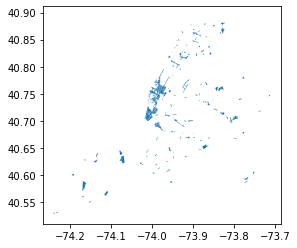

In [10]:
gdf_zoning[gdf_zoning.zone_c == "CC"].plot()

In [11]:
gdf_zoning.to_csv(f"result/gdf_zoning_{VERSION}.csv",index=False)

## POI data 

In [12]:
df_poi = gpd.read_file(os.path.join(p_data,"nycpoi","PointOfInterest.shp")).to_crs("epsg:4326") \
            .convert_dtypes().astype({'FACI_DOM': int})

# generate unique code for each poi type
df_poix = df_poi[["FACILITY_T","FACI_DOM","NAME","geometry"]]
combine_code = lambda x:f"{x['FACILITY_T']:02d}{x['FACI_DOM']:02d}"
df_poix["code"] = df_poi.apply(lambda x: combine_code(x), axis=1) 

## drop useless cols
df_poix = df_poix.drop(["FACILITY_T","FACI_DOM"],axis=1)

# to gdf
gdf_poi = gpd.GeoDataFrame(df_poix, geometry="geometry",crs="epsg:4326")

# map code to category
gdf_poi["type"] = gdf_poi["code"].astype(str).apply(lambda x:POICODE[x])

In [13]:
print(f"data shape: {gdf_poi.shape}")
gdf_poi.sample(5)

data shape: (19300, 4)


,NAME,geometry,code,type
4925,POLAND CONSULATE,POINT (-73.98129 40.74971),0804,Government|Consulate
2640,BOULEVARD SENIOR CENTER,POINT (-73.88162 40.66006),0503,Social Services|Adult Day Care
7900,RAINBOW EARLY HEAD START,POINT (-73.92389 40.81259),0502,Social Services|Day Care Center
4468,WHITE CROSS CLUB STORAGE,POINT (-73.81579 40.83119),0410,Recreational|Other
18578,FORT TRYON PARK ARDEN ST ENTRANCE,POINT (-73.92923 40.86461),0401,Recreational|Park


In [14]:
# largest number of POIs
gdf_poi.groupby("type")["geometry"].count().sort_values(ascending=False)[:5]

type
Residential|Public Housing Development    2715
Recreational|Park                         1439
Social Services|Day Care Center           1227
Religious|Church                          1221
Recreational|Playground                    991
Name: geometry, dtype: int64

Text(0.5, 1.0, 'POI Frequences')

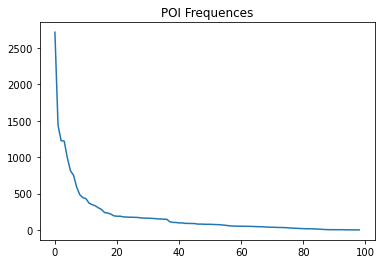

In [15]:
freq = gdf_poi.groupby("code")["geometry"].count() \
        .sort_values(ascending= False).values
plt.plot(freq)
plt.title("POI Frequences")

In [37]:
# gdf_poi.to_csv(f"result/gdf_poi_{VERSION}.csv",index=False)
gdf_poi.to_pickle(f"result/gdf_poi_{VERSION}.pkl")

<AxesSubplot:>

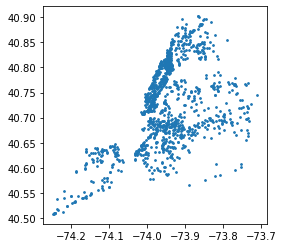

In [17]:
gdf_poi[gdf_poi["code"]=="0901"].plot(markersize=3) # church

* Poi classification system from [DataSource](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_PointsOfInterest.md)

1 Residential  
2 Education Facility  
3 Cultural Facility  
4 Recreational Facility  
5 Social Services   
6 Transportation Facility  
7 Commercial  
8 Government Facility (non public safety)  
9 Religious Institution  
10 Health Services  
11 Public Safety  
12 Water  
13 Miscellaneous  

## Taxi trips

In [18]:
df_tf_green = pd.read_csv(p_greentaxi,low_memory=False)
print(df_tf_green.shape)

df_tf_yellow = pd.read_csv(p_yellowtaxi,low_memory=False)
print(df_tf_yellow.shape)

(1510722, 21)
(11382049, 19)


In [19]:
# rename columns to concat
df_tf_yellow_R = df_tf_yellow[['tpep_pickup_datetime','tpep_dropoff_datetime','pickup_longitude', 'pickup_latitude', 
                               'dropoff_longitude', 'dropoff_latitude', 'trip_distance', 'passenger_count']]
    
df_tf_green_R = df_tf_green[['lpep_pickup_datetime','Lpep_dropoff_datetime','Pickup_longitude', 'Pickup_latitude', 
                             'Dropoff_longitude', 'Dropoff_latitude','Trip_distance', 'Passenger_count']]
df_tf_green_R.columns  = df_tf_yellow_R.columns

df_trips = pd.concat([df_tf_yellow_R, df_tf_green_R]).reset_index(drop=True)

In [20]:
# simplify col names
df_trips.columns = ["put","dot",'pu_lon',"pu_lat","do_lon","do_lat","dis","pasg"]

### Date feature extraction

In [21]:
df_trips['put'] = pd.to_datetime(df_trips['put'])
df_trips['dot'] = pd.to_datetime(df_trips['dot'])

df_trips["delta"] = df_trips["dot"] - df_trips["put"] ## fastest way to calculate the time delta

df_trips["delta"] = df_trips["delta"].astype("timedelta64[s]").astype(int)

In [22]:
# Extracte date features
df_trips = date_features(df_trips,"put")

### filter outliers

In [23]:
## bounding box
[gdf_zoning.bounds.minx.min(),gdf_zoning.bounds.maxx.max(),gdf_zoning.bounds.miny.min(),gdf_zoning.bounds.maxy.max()]

[-74.25625312936339, -73.70015360952254, 40.49111261274054, 40.916512995969605]

In [24]:
df_trips = df_trips[(df_trips["pu_lon"] > -74.3)&(df_trips["pu_lon"] < -73.5) &
                    (df_trips["pu_lat"] >  40.4)&(df_trips["pu_lat"] <  41) &
                    (df_trips["do_lon"] > -74.3)&(df_trips["do_lon"] < -73.5) &
                    (df_trips["do_lat"] >  40.4)&(df_trips["do_lat"] <  41)]

In [25]:
df_trips = df_trips[df_trips["delta"] > 0 ]

In [26]:
# average speed
df_trips["speed"] = df_trips["dis"]/df_trips["delta"] # km/s 
df_trips = df_trips[(df_trips["speed"]< 0.05) &(df_trips["speed"]>= 0) ] # should less than 0.05 km/s = 180 km/h

<AxesSubplot:>

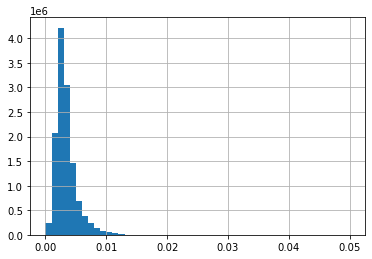

In [27]:
df_trips["speed"].hist(bins=50)

In [28]:
# df_trips.loc[df_trips["speed"].idxmax()].speed  # max speed trip

In [29]:
df_trips = df_trips.reset_index(drop=True)

In [30]:
df_trips.head()

,put,dot,pu_lon,pu_lat,do_lon,do_lat,dis,pasg,delta,put_day,put_hour,put_weekend,speed
0,2016-02-25 17:24:20,2016-02-25 17:27:20,-73.947250,40.763771,-73.992012,40.735390,0.70,2,180,25,17,0,0.003889
1,2016-02-25 23:10:50,2016-02-25 23:31:50,-73.983017,40.750992,-73.988586,40.758839,5.52,2,1260,25,23,0,0.004381
2,2016-02-01 00:00:01,2016-02-01 00:10:52,-73.992340,40.758202,-73.964355,40.757977,1.99,6,651,1,0,0,0.003057
3,2016-02-01 00:00:04,2016-02-01 00:05:16,-73.981453,40.749722,-73.982323,40.763985,1.50,1,312,1,0,0,0.004808
4,2016-02-01 00:00:05,2016-02-01 00:20:59,-74.000603,40.729755,-73.951324,40.669834,5.60,1,1254,1,0,0,0.004466


In [31]:
# # hugely time-consuming
# df_trips.to_csv(f"result/df_trips_{VERSION}.csv",index=False)

## Transform trips to flows between regions

In [32]:
##  spatial join based on lon lat and zoning boundary to get origin id of flows
gdf_trips_origin = gpd.GeoDataFrame(df_trips, crs="epsg:4326", \
                       geometry=gpd.points_from_xy(df_trips.pu_lon, df_trips.pu_lat))

# https://gis.stackexchange.com/questions/175228/geopandas-spatial-join-extremely-slow

gdf_tf_o = sjoin(gdf_trips_origin, gdf_zoning[["geometry"]], how="inner", op="within") \
            .rename(columns={"index_right":"Origin_ID"})

In [33]:
##  spatial join based on lon lat and zoning boundary to get destiny id of flows
df_tf_o = pd.DataFrame(gdf_tf_o)
gdf_tf_od = gpd.GeoDataFrame(df_tf_o, crs="epsg:4326", \
                geometry=gpd.points_from_xy(df_tf_o.do_lon, df_tf_o.do_lat))

gdf_tf_od = sjoin(gdf_tf_od, gdf_zoning[["geometry"]], how="inner",op="within") \
                .rename(columns={"index_right":"Destiny_ID"})

In [34]:
# Method chaining to avoid naming variables
# drop useless lon lat cols --> simplify col names --> add zoning type col to od flow --> 
# assign travel categories based on zoning type
df_tf_odRegion = pd.DataFrame(gdf_tf_od[["Origin_ID","Destiny_ID", "put_day","put_hour","put_weekend","pasg"]]) \
                    .rename(columns= {"put_day":"dayofmonth","put_hour":"hour","put_weekend":"weekend"}) \
                    .merge(gdf_zoning[["zone_c"]],left_on= "Origin_ID",right_index=True) \
                    .merge(gdf_zoning[["zone_c"]],left_on= "Destiny_ID",right_index=True,suffixes=("_origin","_desitny")) \
                    .assign(zone_c_od=lambda x: x['zone_c_origin']+x['zone_c_desitny']) \
                    .astype({'zone_c_od': 'category'})

In [35]:
df_tf_odRegion.to_csv(f"result/df_tf_odRegion_{VERSION}.csv",index=False)